# Capstone: Exploratory Prediction Modeling

## Imports & Utilities

### Imports

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns


# Import utilities
# import pathlib
import time

# Export dataFrame's as images
import dataframe_image as dfi

# import project utils
import sys
sys.path.append('../src')

import data_utils
from data_utils import Config

import graph_utils

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, roc_auc_score, log_loss
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve

from xgboost import XGBClassifier
import xgboost as xgb

from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

In [5]:
# Configure logging
import logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

# logging.getLogger().setLevel(logging.DEBUG)
# logging.getLogger().setLevel(logging.INFO)

### Utility Functions

In [7]:
def time_secs_to_msg(lapse_time_secs, mins_label='m', secs_label='s'):
    if lapse_time_secs <= 60:
        return f'{lapse_time_secs%60:.2f}{secs_label}'
    else:
        return f'{lapse_time_secs//60:,.0f}{mins_label} {lapse_time_secs%60:.2f}{secs_label}'

In [8]:
def log_optimizer_status_cv(optimizer_results):
    """
    Summarizes optimizer results for each iteration so we can see what params are impactful

    :params optimizer_results: Optimizer data passed in the callback
    """

    iter_num = len(optimizer_results["x_iters"])
    # print(f'... Iteration #{iter_num} Best(score: {optimizer_results["func_vals"][iter_num-1]:,.4f}, best_params: {optimizer_results["x"]})')
    print('... Iteration #{} Best(score: {:,.4f}, best_params: {})'
          .format(iter_num, optimizer_results["func_vals"][iter_num-1], optimizer_results["x"]))
    # print(f'... opt_r={optimizer_results}')

In [9]:
def build_results_row(name, model, Xtr, Xte, ytr, yte, optimizer=None):
    """
    Given the model and training/test sets, builds a row of metrics for reporting the results

    :param name: Name/Description of model
    :param model: Fully constructed model instance - will call fit() and predict() to get metrics
    :param Xtr: X_train - scale before calling
    :param Xte: X_test - scale before calling
    :param ytr: Y_train set
    :param yteL: Y_test set
    :param optimizer: If using CV for optimization, pass in the optimizer here
    """

    if optimizer is None:
        use_best = False
    else:
        use_best = True
        # clf = optimizer
        
    print(f'{name}: Starting (use_best={use_best})', flush=True)
    start_time = time.time()

    # train the model
    clf = None
    if (use_best):
        clf = optimizer.fit(Xtr, ytr, callback=log_optimizer_status_cv)
    else:
        clf = model.fit(Xtr, ytr)
        
    # Save fit time
    fit_time = time.time() - start_time
    logging.debug(f'{name}: Fitted: {fit_time} secs')

    # if we're tuning then use best_estimator
    if use_best:
        clf = optimizer.best_estimator_
        logging.debug(f'{name}: Best Model={clf}')
        logging.debug(f'{name}: Best Params={optimizer.best_params_}')

    # get the predictions / probabilities
    y_preds = clf.predict(Xte)
    y_probs_full = clf.predict_proba(Xte)
    y_probs = y_probs_full[:, 1]

    logging.debug(f'{name}: Got preds/probs')

    cm = confusion_matrix(yte, y_preds)
    logging.debug(f'{name}: cm.shape: {cm.shape}')

    # Get metrics
    row = {
        'Train Time': time_secs_to_msg(fit_time),
        'Train Accuracy': f'{clf.score(Xtr, ytr)*100:.2f}%',
        'Test Accuracy': f'{clf.score(Xte, yte)*100:.2f}%',
        'Precision': f'{precision_score(yte, y_preds, average="weighted")*100:.2f}%',  # for multi-class with imbalance
        'Recall': f'{recall_score(yte, y_preds, average="weighted")*100:.2f}%',
        'F1': f'{f1_score(yte, y_preds, average="weighted")*100:.2f}%',
        'AUC': f'{roc_auc_score(yte, y_probs_full, average="weighted", multi_class="ovr")*100:.2f}%',    # faster with imbalanced multi-class cases
        'LogLoss': f'{log_loss(yte, y_probs_full, labels=np.unique(yte)):.4f}',
        'preds': y_preds,
        'probs': y_probs,
        'cm': cm,
        'params': clf.get_params(),
        'best_params': None,
        'best_model': clf,
    }
    if use_best:
        row.update({'best_params': dict(optimizer.best_params_)})
        
    logging.debug(f'{name}: Got metrics')
    
    print(f'{name}: Done: {time_secs_to_msg(time.time()-start_time)}')

    return row

## The Data: San Francisco Police Department Incident Reports

### Read the Data

We use the utility function `data_utils.select_sample_csv_file()` function to read in the appropriate sampled file for debugging and modeling - the sample percentage selects the appropriate file:

In [13]:
# Which dataset to work from? Select sample size percentage

sample_file = data_utils.select_sample_csv_file(pct=10)
# sample_file = data_utils.select_sample_csv_file(pct=100)
# sample_file = data_utils.select_sample_csv_file(pct=75)
# sample_file = data_utils.select_sample_csv_file(pct=50)
# sample_file = data_utils.select_sample_csv_file(pct=25)

print(f'Selected sample file: {sample_file}')

Selected sample file: ../data/incidents_clean_10_pct.csv


Read in the pre-cleansed file so we can get to data modeling quickly:

In [15]:
current_raw_df, current_clean_df = data_utils.get_clean_data_from_csv(sample_file)

Reading file: ../data/incidents_clean_10_pct.csv ... Done: 89,458 rows, 37 columns
... Converting datetime to timeseries ... Done
... Setting index to datetime ... Done
Done


Apply the learnings from the EDA to our data:

In [17]:
data = data_utils.preprocess_data(current_raw_df.copy())

Pre-processing ... 
... Dropping unwanted columns ... 
... preprocess_drop_cols: Column Unnamed: 0 dropped
... preprocess_drop_cols: Column esncag_-_boundary_file dropped
... preprocess_drop_cols: Column central_market/tenderloin_boundary_polygon_-_updated dropped
... preprocess_drop_cols: Column civic_center_harm_reduction_project_boundary dropped
... preprocess_drop_cols: Column hsoc_zones_as_of_2018-06-05 dropped
... preprocess_drop_cols: Column invest_in_neighborhoods_(iin)_areas dropped
... preprocess_drop_cols: Column report_type_code dropped
... preprocess_drop_cols: Column report_type_description dropped
... preprocess_drop_cols: Column filed_online dropped
... preprocess_drop_cols: Column intersection dropped
... preprocess_drop_cols: Column cnn dropped
... preprocess_drop_cols: Column point dropped
... preprocess_drop_cols: Column supervisor_district dropped
... preprocess_drop_cols: Column supervisor_district_2012 dropped
... preprocess_drop_cols: Column current_supervisor_d

In [18]:
# Fix data value artifacts that were discovered during EDA
data = data_utils.fix_data_artifacts(data)

Fixing data artifacts (in-place) ... 
... Category column:
    ..."Human Trafficking*"
    ..."Motor Vehicle Theft"
    ..."Weapons Offence"
Done


In [19]:
data = data_utils.apply_synthetic_features(data)

Generating synthetic feature columns (in-place) ... 
... Adding columns ['hour', 'minute', 'day', 'month']'
... Adding column ['weekend']
... Adding column ['season']
... Adding column ['holiday']
Done


In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 82888 entries, 2024-08-01 08:01:00 to 2018-10-02 16:53:00
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             82888 non-null  object 
 1   time             82888 non-null  object 
 2   year             82888 non-null  int64  
 3   day_of_week      82888 non-null  object 
 4   category         82888 non-null  object 
 5   resolution       82888 non-null  object 
 6   police_district  82888 non-null  object 
 7   neighborhood     82888 non-null  object 
 8   latitude         82888 non-null  float64
 9   longitude        82888 non-null  float64
 10  hour             82888 non-null  int64  
 11  minute           82888 non-null  int64  
 12  day              82888 non-null  int64  
 13  month            82888 non-null  int64  
 14  weekend          82888 non-null  int64  
 15  season           82888 non-null  object 
 16  holiday          82888 

## Summary of EDA

After cleaning the data and performing basic EDA, we have established the following:

1. Target variable `category`
   * Evenly spread across time
   * Incidence of crimes is extremely skewed/unbalanced by category. Larceny (29.02%) by far outweighing the other top-10 categories with each being in the single digits
3. Features impacting `category`
   * Affected by incident time and date components: date, time, day of week, month, year, etc
   * Affected by police disctrict
   * Affect by latitude and logitude (TODO: need visualization)
4. Added new synthetic columns like weekends, seasons, holidays, etc to better handle temporal semantics to improve our predictions
5. We artificially removed nulls (TODO: will come back to impute data later)

## Feature Engineering

In [24]:
data.head(2)

,date,time,year,day_of_week,category,resolution,police_district,neighborhood,latitude,longitude,hour,minute,day,month,weekend,season,holiday
datetime,,,,,,,,,,,,,,,,,
2024-08-01 08:01:00,2024/08/01,08:01,2024,Thursday,Other Miscellaneous,Open or Active,Mission,Mission,37.768272,-122.419983,8,1,1,8,0,Summer,False
2021-11-25 23:30:00,2021/11/25,23:30,2021,Thursday,Burglary,Open or Active,Northern,Haight Ashbury,37.773757,-122.432467,23,30,25,11,0,Fall,False


In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 82888 entries, 2024-08-01 08:01:00 to 2018-10-02 16:53:00
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             82888 non-null  object 
 1   time             82888 non-null  object 
 2   year             82888 non-null  int64  
 3   day_of_week      82888 non-null  object 
 4   category         82888 non-null  object 
 5   resolution       82888 non-null  object 
 6   police_district  82888 non-null  object 
 7   neighborhood     82888 non-null  object 
 8   latitude         82888 non-null  float64
 9   longitude        82888 non-null  float64
 10  hour             82888 non-null  int64  
 11  minute           82888 non-null  int64  
 12  day              82888 non-null  int64  
 13  month            82888 non-null  int64  
 14  weekend          82888 non-null  int64  
 15  season           82888 non-null  object 
 16  holiday          82888 

### Time-based Features

#### Encoding: Dates

Now let's encode `day_of_week` to numeric values:

In [29]:
enc_dow = LabelEncoder()
enc_dow.fit(data.day_of_week.unique())
data['dow'] = enc_dow.transform(data.day_of_week)

# data[['dow', 'day_of_week']].head(5)

In [30]:
# Create mask for seasons
seasons = {0:'Winter', 1:'Spring', 2:'Summer', 3:'Fall'}

data['season'] = data.month.map(lambda x: seasons[((x % 12) // 3)])

# data[['month', 'season']].head(5)

Encoding `season`:

In [32]:
enc_season = LabelEncoder()
enc_season.fit(data.season.unique())
data['season'] = enc_season.transform(data.season)

# data[['month', 'season']].head(5)

Done with time-based columns. Let's mark the redundant columns to be dropped after feature engineering:

In [34]:
drop_encoded_cols = ['date', 'time', 'day_of_week']

### Categorical Features

#### Encoding: Resolution

We will also drop the resolution column since it doesn't impact crime prediction:

In [38]:
data.resolution.value_counts()

resolution
Open or Active          66265
Cite or Arrest Adult    16623
Name: count, dtype: int64

In [39]:
drop_encoded_cols.append('resolution')

#### Encoding: Category

In [41]:
enc_cat = LabelEncoder()
enc_cat.fit(data.category.unique())
data.category = enc_cat.transform(data.category)

#### Encoding: Police District

In [43]:
enc_pd = LabelEncoder()
enc_pd.fit(data.police_district.unique())
data['pd'] = enc_pd.transform(data.police_district)

#### Encoding: Neighborhood

In [45]:
enc_hood = LabelEncoder()
enc_hood.fit(data.neighborhood.unique())
data.neighborhood = enc_hood.transform(data.neighborhood)

We are now done with the Categorical features and can now drop the redundant encoded columns that have been converted to other features:

In [47]:
drop_encoded_cols.append('police_district')

print(f'Dropping encoded columns: {drop_encoded_cols}')
data.drop(columns=drop_encoded_cols, inplace=True)

Dropping encoded columns: ['date', 'time', 'day_of_week', 'resolution', 'police_district']


### Geo-based Features

According to [LatLong.net](https://www.latlong.net/place/san-francisco-bay-area-ca-usa-32614.html) the San Francisco County is bounded by the following rectangle:

* Latitude Range:
  * Northern limit: 37.828724° N
  * Southern limit: 37.733795° N
* Longitude Range:
  * Western limit: -122.446747° W
  * Eastern limit: -122.355537° W

Let's make sure our data is within range.

In [50]:
print(f'Latitude: Min: {data.latitude.min()}, Max: {data.latitude.max()}')

Latitude: Min: 37.70798825918467, Max: 37.82999075468863


In [51]:
print(f'Longitude: Min: {data.longitude.min()}, Max: {data.longitude.max()}')

Longitude: Min: -122.5119400024414, Max: -122.36373901367188


Based on this, our latitude and longitude values are within limits, i.e. some crimes may have happened in the Bay or Treasure Island. We will not change any values.

In [53]:
data.head(2)

,year,category,neighborhood,latitude,longitude,hour,minute,day,month,weekend,season,holiday,dow,pd
datetime,,,,,,,,,,,,,,
2024-08-01 08:01:00,2024,26,18,37.768272,-122.419983,8,1,1,8,0,2,False,4,3
2021-11-25 23:30:00,2021,2,8,37.773757,-122.432467,23,30,25,11,0,0,False,4,4


In [54]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 82888 entries, 2024-08-01 08:01:00 to 2018-10-02 16:53:00
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          82888 non-null  int64  
 1   category      82888 non-null  int64  
 2   neighborhood  82888 non-null  int64  
 3   latitude      82888 non-null  float64
 4   longitude     82888 non-null  float64
 5   hour          82888 non-null  int64  
 6   minute        82888 non-null  int64  
 7   day           82888 non-null  int64  
 8   month         82888 non-null  int64  
 9   weekend       82888 non-null  int64  
 10  season        82888 non-null  int64  
 11  holiday       82888 non-null  bool   
 12  dow           82888 non-null  int64  
 13  pd            82888 non-null  int64  
dtypes: bool(1), float64(2), int64(11)
memory usage: 8.9 MB


In [55]:
# data.to_csv('../data/incidents_10.csv')

## Data Preparation

### Create Train/Test Splits

In [58]:
X = data.drop('category', axis='columns')
y = data['category']

In [59]:
# OneHot Encode the features and drop the first value to reduce multicollinearity
X = pd.get_dummies(X, drop_first=True)

In [60]:
# Consistent random_state for the project
print(f'Project-wide random_state: {Config.RANDOM_STATE}')

Project-wide random_state: 42


In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    stratify=y, random_state=Config.RANDOM_STATE)

In [62]:
print('AFTER TRAIN_TEST_SPLIT: Data{}, X_train{}, X_test{}, y_train{}, y_test{}'
      .format(data.shape, X_train.shape, X_test.shape, y_train.shape, y_test.shape))

AFTER TRAIN_TEST_SPLIT: Data(82888, 14), X_train(66310, 13), X_test(16578, 13), y_train(66310,), y_test(16578,)


In [63]:
# spot-check feature encoding
X.T.iloc[:, 0:5]

datetime,2024-08-01 08:01:00,2021-11-25 23:30:00,2018-06-20 21:00:00,2022-07-06 12:41:00,2021-02-27 23:02:00
year,2024,2021,2018,2022,2021
neighborhood,18,8,23,33,19
latitude,37.768272,37.773757,37.723642,37.777457,37.770063
longitude,-122.419983,-122.432467,-122.461251,-122.413158,-122.403878
hour,8,23,21,12,23
minute,1,30,0,41,2
day,1,25,20,6,27
month,8,11,6,7,2
weekend,0,0,0,0,1
season,2,0,2,2,3


### Feature Scaling

In [65]:
# Scale the data - we'll use StandardScaler for the baseline model
logging.debug('Scaling data')
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print('AFTER SCALING: Data{}, X_train_scaled{}, X_test_scaled{}, y_train{}, y_test{}'
      .format(data.shape, X_train_scaled.shape, X_test_scaled.shape, y_train.shape, y_test.shape))

AFTER SCALING: Data(82888, 14), X_train_scaled(66310, 13), X_test_scaled(16578, 13), y_train(66310,), y_test(16578,)


## Model Exploration

The task of classifying the incident types based on a set of historical attrirbutes (features) and predicting on similar attributes is a **multiclass classification** problem. We will now experiment on some ML models that are generally used for similar problems to see what would be the best choice for us.

We will evaluate the following models:

* Simple classification models
  * `DummyClassifier` to get a baseline for our project
  * `LogisticRegression` with L1 Regularization
* Multiclass classifiers
  * `KNeighborsClassifier`
* Ensemble methods: Since our dataset has high variability with a lot of numerical and cagtegorical features with a range of mean and variance, we plan to employ ensemble methods and tune them for best results
  * `RandomForestClassifier`
  * `XGBClassifier`: We considered `XGLite` but selected XGBoost as it provides better model explainability features like SHAP values, which we expect to be able to use in explaining our results

We will now evaluate different models for predicting the Crime Category from our features:

In [69]:
X_train.columns

Index(['year', 'neighborhood', 'latitude', 'longitude', 'hour', 'minute',
       'day', 'month', 'weekend', 'season', 'holiday', 'dow', 'pd'],
      dtype='object')

### Evaluation Metrics

In this project, we are predicting or classifyig across 49 crime categories. We will use two evaluation metrics to compare our models:

1. **Accuracy**: Measures the proportion of correct predictions over all predictions made. The accuracy benchmark is 1/49 or 2.04% given our crime categories
2. **Log_Loss**: Measures the accuracy of a classifier by penalizing false classifications. It does this by taking the negative logarithm of the predicted probability for the true class. The goal is to minimize this loss, meaning that higher probabilities are assigned to the correct classes. Log loss is a powerful way to evaluate not just if the model is making the right predictions, but how confident it is in those predictions. A lower log loss indicates a model that is both accurate and confident.
   * TODO: Benchmark???

While accuracy provides a simple measure of correctness, log-loss offers a more nuanced view by considering how confident those predictions are. A model that predicts with 51% confidence for the correct class will have the same accuracy as one that predicts with 99% confidence, but their log loss will be very different. The 99%-confident model will have a much lower log loss.

We'll use them together for a comprehensive evaluation and to learn more about them.

The `build_results_row` utility function will be used to standardize the recording and reporting of our model exploration: 

### Establishing a Baseline

#### DummyClassifier

We will use the Scikit-Learn DummyClassifier method to get a baseline for our predictions using the different strategies provided by the library:

In [76]:
# let's start saving the results for reporting out
results_defaults = {}

# Reports won't print all the columns
report_cols = ['Train Time', 
               'Train Accuracy', 'Test Accuracy', 'LogLoss',
               'Precision', 'Recall', 'F1', 'AUC']

In [77]:
# Define the DummyClassifier models we want to test
models_dummy = {
    'DummyClassifier: uniform': DummyClassifier(strategy='uniform', random_state=Config.RANDOM_STATE),
    'DummyClassifier: most_frequent': DummyClassifier(strategy='most_frequent', random_state=Config.RANDOM_STATE),
    'DummyClassifier: stratified': DummyClassifier(strategy='stratified', random_state=Config.RANDOM_STATE),
}

In [78]:
# logging.getLogger().setLevel(logging.DEBUG)

# Get metrics row for the report - will fit() and predict() to generate metrics
for name, model in models_dummy.items():
    results_defaults[name] = build_results_row(name, model, X_train_scaled, X_test_scaled, y_train, y_test)

# logging.getLogger().setLevel(logging.INFO)

DummyClassifier: uniform: Starting (use_best=False)
DummyClassifier: uniform: Done: 0.42s
DummyClassifier: most_frequent: Starting (use_best=False)


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


DummyClassifier: most_frequent: Done: 0.41s
DummyClassifier: stratified: Starting (use_best=False)
DummyClassifier: stratified: Done: 0.73s


The warning above is from the precision calculation within scikit-learn, and highlights that some labels have no predicted samples, which results in precision being undefined for those labels. We can ignore the warning since we're using accuracy as our key evaluation metric. We could use `prescion_score(zero_division=0)` to suppress the warning, but we'll ignore it instead to ensure we're aware of the condition.

In [80]:
# View results by highest Test Accuracy and lowest log_loss
results_defaults_df = pd.DataFrame(results_defaults).T.sort_values(by=['Test Accuracy', 'LogLoss'], ascending=[False, True])

In [81]:
# format the output to hilite results
hilite=Config.TBL_HILITE_COLOR
results_defaults_styled = results_defaults_df[report_cols].style.map(lambda val: f'background-color: {hilite}',
                                                                     subset=['Test Accuracy','LogLoss'])
results_defaults_styled = results_defaults_styled.set_table_styles({
    'LogLoss': [{'selector': 'th', 'props': [('background-color', hilite)]}],
    'Test Accuracy': [{'selector': 'th', 'props': [('background-color', hilite)]}]
}, overwrite=False)
results_defaults_styled

,Train Time,Train Accuracy,Test Accuracy,LogLoss,Precision,Recall,F1,AUC
DummyClassifier: most_frequent,0.01s,28.97%,28.97%,25.6032,8.39%,28.97%,13.01%,50.00%
DummyClassifier: uniform,0.01s,2.28%,2.27%,3.8067,11.30%,2.27%,3.19%,50.00%
DummyClassifier: stratified,0.00s,11.49%,11.28%,31.9779,11.32%,11.28%,11.30%,49.84%


#### Default Models

We will now explore the selected models with out-of-the-box default settings of their hyperparameters to get a baseline per model class.

In [84]:
# Define the default models
models_default = {
    'LogisticRegression (Default)': LogisticRegression(random_state=Config.RANDOM_STATE),
    'KNeighborsClassifier (Default)': KNeighborsClassifier(),
    'RandomForestClassifier (Default)': RandomForestClassifier(random_state=Config.RANDOM_STATE),
    'XGBClassifier (Default)': XGBClassifier(random_state=Config.RANDOM_STATE)
}

In [85]:
# logging.getLogger().setLevel(logging.DEBUG)

# Get metrics row for the report - will fit() and predict() to generate metrics
for name, model in models_default.items():
    results_defaults[name] = build_results_row(name, model, X_train_scaled, X_test_scaled, y_train, y_test)

# logging.getLogger().setLevel(logging.INFO)

LogisticRegression (Default): Starting (use_best=False)


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LogisticRegression (Default): Done: 3m 33.31s
KNeighborsClassifier (Default): Starting (use_best=False)


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


KNeighborsClassifier (Default): Done: 2m 5.42s
RandomForestClassifier (Default): Starting (use_best=False)


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


RandomForestClassifier (Default): Done: 46.94s
XGBClassifier (Default): Starting (use_best=False)


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


XGBClassifier (Default): Done: 5m 53.16s


In [86]:
# View results by highest Test Accuracy and lowest log_loss
results_defaults_df = pd.DataFrame(results_defaults).T.sort_values(by=['Test Accuracy', 'LogLoss'], ascending=[False, True])

In [87]:
# format the output to hilite results
hilite=Config.TBL_HILITE_COLOR
results_defaults_styled = results_defaults_df[report_cols].style.map(lambda val: f'background-color: {hilite}',
                                                                     subset=['Test Accuracy','LogLoss'])
results_defaults_styled = results_defaults_styled.set_table_styles({
    'LogLoss': [{'selector': 'th', 'props': [('background-color', hilite)]}],
    'Test Accuracy': [{'selector': 'th', 'props': [('background-color', hilite)]}]
}, overwrite=False)
results_defaults_styled

,Train Time,Train Accuracy,Test Accuracy,LogLoss,Precision,Recall,F1,AUC
XGBClassifier (Default),5m 47.05s,54.21%,31.61%,2.5526,23.32%,31.61%,23.74%,70.78%
RandomForestClassifier (Default),34.64s,98.39%,30.84%,5.0575,22.27%,30.84%,22.71%,67.80%
LogisticRegression (Default),3m 32.75s,29.19%,29.48%,2.6361,14.70%,29.48%,15.17%,63.20%
DummyClassifier: most_frequent,0.01s,28.97%,28.97%,25.6032,8.39%,28.97%,13.01%,50.00%
KNeighborsClassifier (Default),0.18s,41.14%,22.05%,20.7502,16.28%,22.05%,17.73%,56.63%
DummyClassifier: uniform,0.01s,2.28%,2.27%,3.8067,11.30%,2.27%,3.19%,50.00%
DummyClassifier: stratified,0.00s,11.49%,11.28%,31.9779,11.32%,11.28%,11.30%,49.84%


In [88]:
# Save results to file for final report
if not Config.SUPPRESS_OUTPUT_FILES:
    dfi.export(results_defaults_styled, Config.IMAGE_DIR / 'table_models_defaults.png')

### Candidate Models

In [90]:
# parameters
VERBOSE=0             # 0: None, 1: Iteration end, 2: Iteration scores
JOBS=-1               # Use all cores

In [91]:
# let's start saving the results for reporting out
results_tuned = {}

# Reports won't print all the columns
report_cols_tuned = ['params', 'Train Time', 
                     'Train Accuracy', 'Test Accuracy', 'LogLoss',
                     'Precision', 'Recall', 'F1', 'AUC']

In [92]:
# Define the candidate models with starting params
models_tuned = {
    
    'LogisticRegression': LogisticRegression(penalty='l1', solver='saga', max_iter=1000, 
                                             verbose=VERBOSE, n_jobs=JOBS, random_state=Config.RANDOM_STATE),

    'RandomForestClassifier': RandomForestClassifier(n_estimators=100, max_depth=15,
                                                     min_samples_leaf=5, min_samples_split=25, 
                                                     random_state=Config.RANDOM_STATE, 
                                                     verbose=VERBOSE, n_jobs=JOBS),

    'XGBClassifier': XGBClassifier(n_estimators=100, objective="multi:softprob", 
                                   n_jobs=JOBS, random_state=Config.RANDOM_STATE),
}

In [93]:
# logging.getLogger().setLevel(logging.DEBUG)

print(f'Settings: verbose={VERBOSE}, n_jobs={JOBS}')

# Get metrics row for the report - will fit() and predict() to generate metrics
for name, model in models_tuned.items():
    results_tuned[name] = build_results_row(name, model, X_train_scaled, X_test_scaled, y_train, y_test)

# logging.getLogger().setLevel(logging.INFO)

Settings: verbose=0, n_jobs=-1
LogisticRegression: Starting (use_best=False)


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LogisticRegression: Done: 3m 39.83s
RandomForestClassifier: Starting (use_best=False)


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


RandomForestClassifier: Done: 9.12s
XGBClassifier: Starting (use_best=False)


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


XGBClassifier: Done: 12m 54.74s


In [94]:
# View results by highest Test Accuracy and lowest log_loss
results_tuned_df = pd.DataFrame(results_tuned).T.sort_values(by=['Test Accuracy', 'LogLoss'], ascending=[False, True])

In [95]:
# format the output to hilite results
hilite=Config.TBL_HILITE_COLOR
results_tuned_styled = results_tuned_df[report_cols_tuned].style.map(lambda val: f'background-color: {hilite}', 
                                                                     subset=['Test Accuracy','LogLoss'])
results_tuned_styled = results_tuned_styled.set_table_styles({
    'params': [{'selector': 'td', 'props': [('max-width', '300px'), 
                                  ('white-space', 'normal'), 
                                  ('word-wrap', 'break-word')]}],
    'LogLoss': [{'selector': 'th', 'props': [('background-color', hilite)]}],
    'Test Accuracy': [{'selector': 'th', 'props': [('background-color', hilite)]}]
}, overwrite=False)
results_tuned_styled

,params,Train Time,Train Accuracy,Test Accuracy,LogLoss,Precision,Recall,F1,AUC
RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 15, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 5, 'min_samples_split': 25, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}",6.79s,39.02%,31.74%,2.5358,20.88%,31.74%,19.64%,70.83%
XGBClassifier,"{'objective': 'multi:softprob', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 100, 'n_jobs': -1, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}",12m 46.20s,54.21%,31.61%,2.5526,23.32%,31.61%,23.74%,70.78%
LogisticRegression,"{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'deprecated', 'n_jobs': -1, 'penalty': 'l1', 'random_state': 42, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}",3m 39.27s,29.19%,29.49%,2.6359,14.72%,29.49%,15.17%,63.21%


In [96]:
# Save results to file for final report
if not Config.SUPPRESS_OUTPUT_FILES:
    dfi.export(results_tuned_styled, Config.IMAGE_DIR / 'table_models_tuned.png')

## Model Tuning

### BayesSearchCV

In [99]:
# BayesSearchCV Tuning parameters
CV=3             # cross-validation splitting strategy: StratifiedKFold=3
VERBOSE=0        # 0: None, 1: Iteration end, 2: Iteration scores
JOBS=-1          # Use all cores
#ITERATIONS=5     # Num of param settings that are sampled. Trades off runtime vs quality of the solution
ITERATIONS=2     # Num of param settings that are sampled. Trades off runtime vs quality of the solution

In [100]:
results_CV = {}

# let's start saving the results for reporting out
results_tuned = {}

# Reports won't print all the columns
report_cols_CV = ['best_params', 'Train Time', 
                  'Train Accuracy', 'Test Accuracy', 'LogLoss',
                  'Precision', 'Recall', 'F1', 'AUC']

In [101]:
# Initialize our models for BayesSearchCV
models = {
    'RandomForestClassifier': RandomForestClassifier(random_state=Config.RANDOM_STATE),
    'XGBClassifier': XGBClassifier(objective="multi:softprob", random_state=Config.RANDOM_STATE),
}

# Define the search spaces for hyperparameter tuning 
model_search_spaces = {
    
    # Define search spaces for RandomForestClassifier
    'RandomForestClassifier': {
        'n_estimators': Integer(50, 100),
        'max_depth': Integer(3, 20),
        'min_samples_split': Integer(2, 20),
        'min_samples_leaf': Integer(1, 10),
        'max_features': Categorical(['sqrt', 'log2', None]),       # None=n_features
    },
    
    # Define search spaces for XGBClassifier
    'XGBClassifier': {
        'n_estimators': Integer(50, 1000),
        'max_depth': Integer(3, 100),
        'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
        'min_child_weight': Integer(1, 10),
        'subsample': Real(0.5, 1.0),
        'colsample_bytree': Real(0.5, 1.0, 'uniform'),
        'colsample_bylevel': Real(0.01, 1.0, 'uniform'),
        'reg_lambda': (1e-9, 1000, 'log-uniform'),
        'reg_alpha': (1e-9, 1.0, 'log-uniform'),
    }
}

In [102]:
logging.getLogger().setLevel(logging.DEBUG)

# Get metrics row for the report - will fit() and predict() to generate metrics
for name, model in models.items():
    
    print(f'{name}: Starting BayesSearchCV optimization ({CV}-fold)', flush=True)
    print(f'Settings: verbose={VERBOSE}, n_jobs={JOBS}, cv={CV}, n_iter={ITERATIONS}')
    
    opt = BayesSearchCV(
        estimator=model,
        search_spaces=model_search_spaces[name],
        scoring = 'neg_log_loss',
        n_iter=ITERATIONS,
        cv=CV,
        n_jobs=JOBS,
        random_state=Config.RANDOM_STATE,
        verbose=VERBOSE
    )

    results_CV[name] = build_results_row(name, model, X_train_scaled, X_test_scaled, y_train, y_test, optimizer=opt)

    print(f'{name}: Done BayesSearchCV optimization ({CV}-fold)', flush=True)

logging.getLogger().setLevel(logging.INFO)

RandomForestClassifier: Starting BayesSearchCV optimization (3-fold)
Settings: verbose=0, n_jobs=-1, cv=3, n_iter=2
RandomForestClassifier: Starting (use_best=True)
... Iteration #1 Best(score: 2.5544, best_params: [10, None, 9, 8, 84])
... Iteration #2 Best(score: 2.6849, best_params: [10, None, 9, 8, 84])


DEBUG: RandomForestClassifier: Fitted: 110.26505994796753 secs
DEBUG: RandomForestClassifier: Best Model=RandomForestClassifier(max_depth=10, max_features=None, min_samples_leaf=9,
                       min_samples_split=8, n_estimators=84, random_state=42)
DEBUG: RandomForestClassifier: Best Params=OrderedDict([('max_depth', 10), ('max_features', None), ('min_samples_leaf', 9), ('min_samples_split', 8), ('n_estimators', 84)])
DEBUG: RandomForestClassifier: Got preds/probs
DEBUG: RandomForestClassifier: cm.shape: (45, 45)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
DEBUG: RandomForestClassifier: Got metrics


RandomForestClassifier: Done: 1m 53.18s
RandomForestClassifier: Done BayesSearchCV optimization (3-fold)
XGBClassifier: Starting BayesSearchCV optimization (3-fold)
Settings: verbose=0, n_jobs=-1, cv=3, n_iter=2
XGBClassifier: Starting (use_best=True)
... Iteration #1 Best(score: 3.2310, best_params: [0.4160029192647807, 0.8638628715886625, 0.2387586688716479, 34, 7, 443, 1.440064730980368e-06, 0.7482570377261556, 0.6522316555182531])
... Iteration #2 Best(score: 2.5605, best_params: [0.8390144719977516, 0.9416576386904312, 0.02806554771929606, 95, 9, 109, 1.7570205641667407e-08, 1.7500432085329334e-05, 0.8178645509395852])


DEBUG: XGBClassifier: Fitted: 984.8679060935974 secs
DEBUG: XGBClassifier: Best Model=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.8390144719977516, colsample_bynode=None,
              colsample_bytree=0.9416576386904312, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.02806554771929606,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=95, max_leaves=None,
              min_child_weight=9, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=109, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)
DEBUG: XGBClassifier: Best Params=OrderedDict([('colsample_bylevel', 0.8390144719977516), ('cols

XGBClassifier: Done: 16m 51.83s
XGBClassifier: Done BayesSearchCV optimization (3-fold)


In [103]:
# View results by highest Test Accuracy and lowest log_loss
results_CV_df = pd.DataFrame(results_CV).T.sort_values(by=['Test Accuracy', 'LogLoss'], ascending=[False, True])

In [104]:
# format the output to hilite results
hilite=Config.TBL_HILITE_COLOR
results_CV_styled = results_CV_df[report_cols_CV].style.map(lambda val: f'background-color: {hilite}', 
                                                                     subset=['Test Accuracy','LogLoss'])
results_CV_styled = results_CV_styled.set_table_styles({
    'best_params': [{'selector': 'td', 'props': [('max-width', '300px'), 
                                                 ('white-space', 'normal'), 
                                                 ('word-wrap', 'break-word')]}],
    'LogLoss': [{'selector': 'th', 'props': [('background-color', hilite)]}],
    'Test Accuracy': [{'selector': 'th', 'props': [('background-color', hilite)]}]
}, overwrite=False)

results_CV_styled

,best_params,Train Time,Train Accuracy,Test Accuracy,LogLoss,Precision,Recall,F1,AUC
XGBClassifier,"{'colsample_bylevel': 0.8390144719977516, 'colsample_bytree': 0.9416576386904312, 'learning_rate': 0.02806554771929606, 'max_depth': 95, 'min_child_weight': 9, 'n_estimators': 109, 'reg_alpha': 1.7570205641667407e-08, 'reg_lambda': 1.7500432085329334e-05, 'subsample': 0.8178645509395852}",16m 24.87s,47.13%,32.47%,2.5438,23.74%,32.47%,22.98%,71.67%
RandomForestClassifier,"{'max_depth': 10, 'max_features': None, 'min_samples_leaf': 9, 'min_samples_split': 8, 'n_estimators': 84}",1m 50.27s,33.39%,31.42%,2.5525,20.99%,31.42%,19.57%,70.00%


In [105]:
# Save results to file for final report
if not Config.SUPPRESS_OUTPUT_FILES:
    dfi.export(results_CV_styled, Config.IMAGE_DIR / 'table_models_CV.png')

## Best Model Evaluation

In [107]:
# Print results for the best-model selected by the optimizer
best_model = opt.best_estimator_
best_model_idx = [name for name, model in models.items() if results_CV[name]['best_model'] == best_model][0]
target_names = np.unique(enc_cat.inverse_transform(data.category))

print('\n\nBest Model:\n\t{}\n\tTest Accuracy: {}\n\tLog-Loss: {}\n\tBest Params: {}\n\nClassification Report:\n\n{}'
      .format(best_model_idx, 
              results_CV[best_model_idx]['Test Accuracy'],
              results_CV[best_model_idx]['LogLoss'],
              results_CV[best_model_idx]['best_params'],
              classification_report(y_test, 
                                    results_CV[best_model_idx]['preds'],
                                    target_names=target_names
                                   ),
             ),
      flush=True
     )



Best Model:
	XGBClassifier
	Test Accuracy: 32.47%
	Log-Loss: 2.5438
	Best Params: {'colsample_bylevel': 0.8390144719977516, 'colsample_bytree': 0.9416576386904312, 'learning_rate': 0.02806554771929606, 'max_depth': 95, 'min_child_weight': 9, 'n_estimators': 109, 'reg_alpha': 1.7570205641667407e-08, 'reg_lambda': 1.7500432085329334e-05, 'subsample': 0.8178645509395852}

Classification Report:

                                          precision    recall  f1-score   support

                                   Arson       0.00      0.00      0.00        51
                                 Assault       0.18      0.13      0.15      1079
                                Burglary       0.26      0.16      0.19       986
                            Case Closure       0.00      0.00      0.00        39
                         Civil Sidewalks       0.40      0.33      0.36        18
                         Courtesy Report       0.00      0.00      0.00        17
                      Disor

/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Confusion Matrix

Generating Confusion Matrix for XGBClassifier:


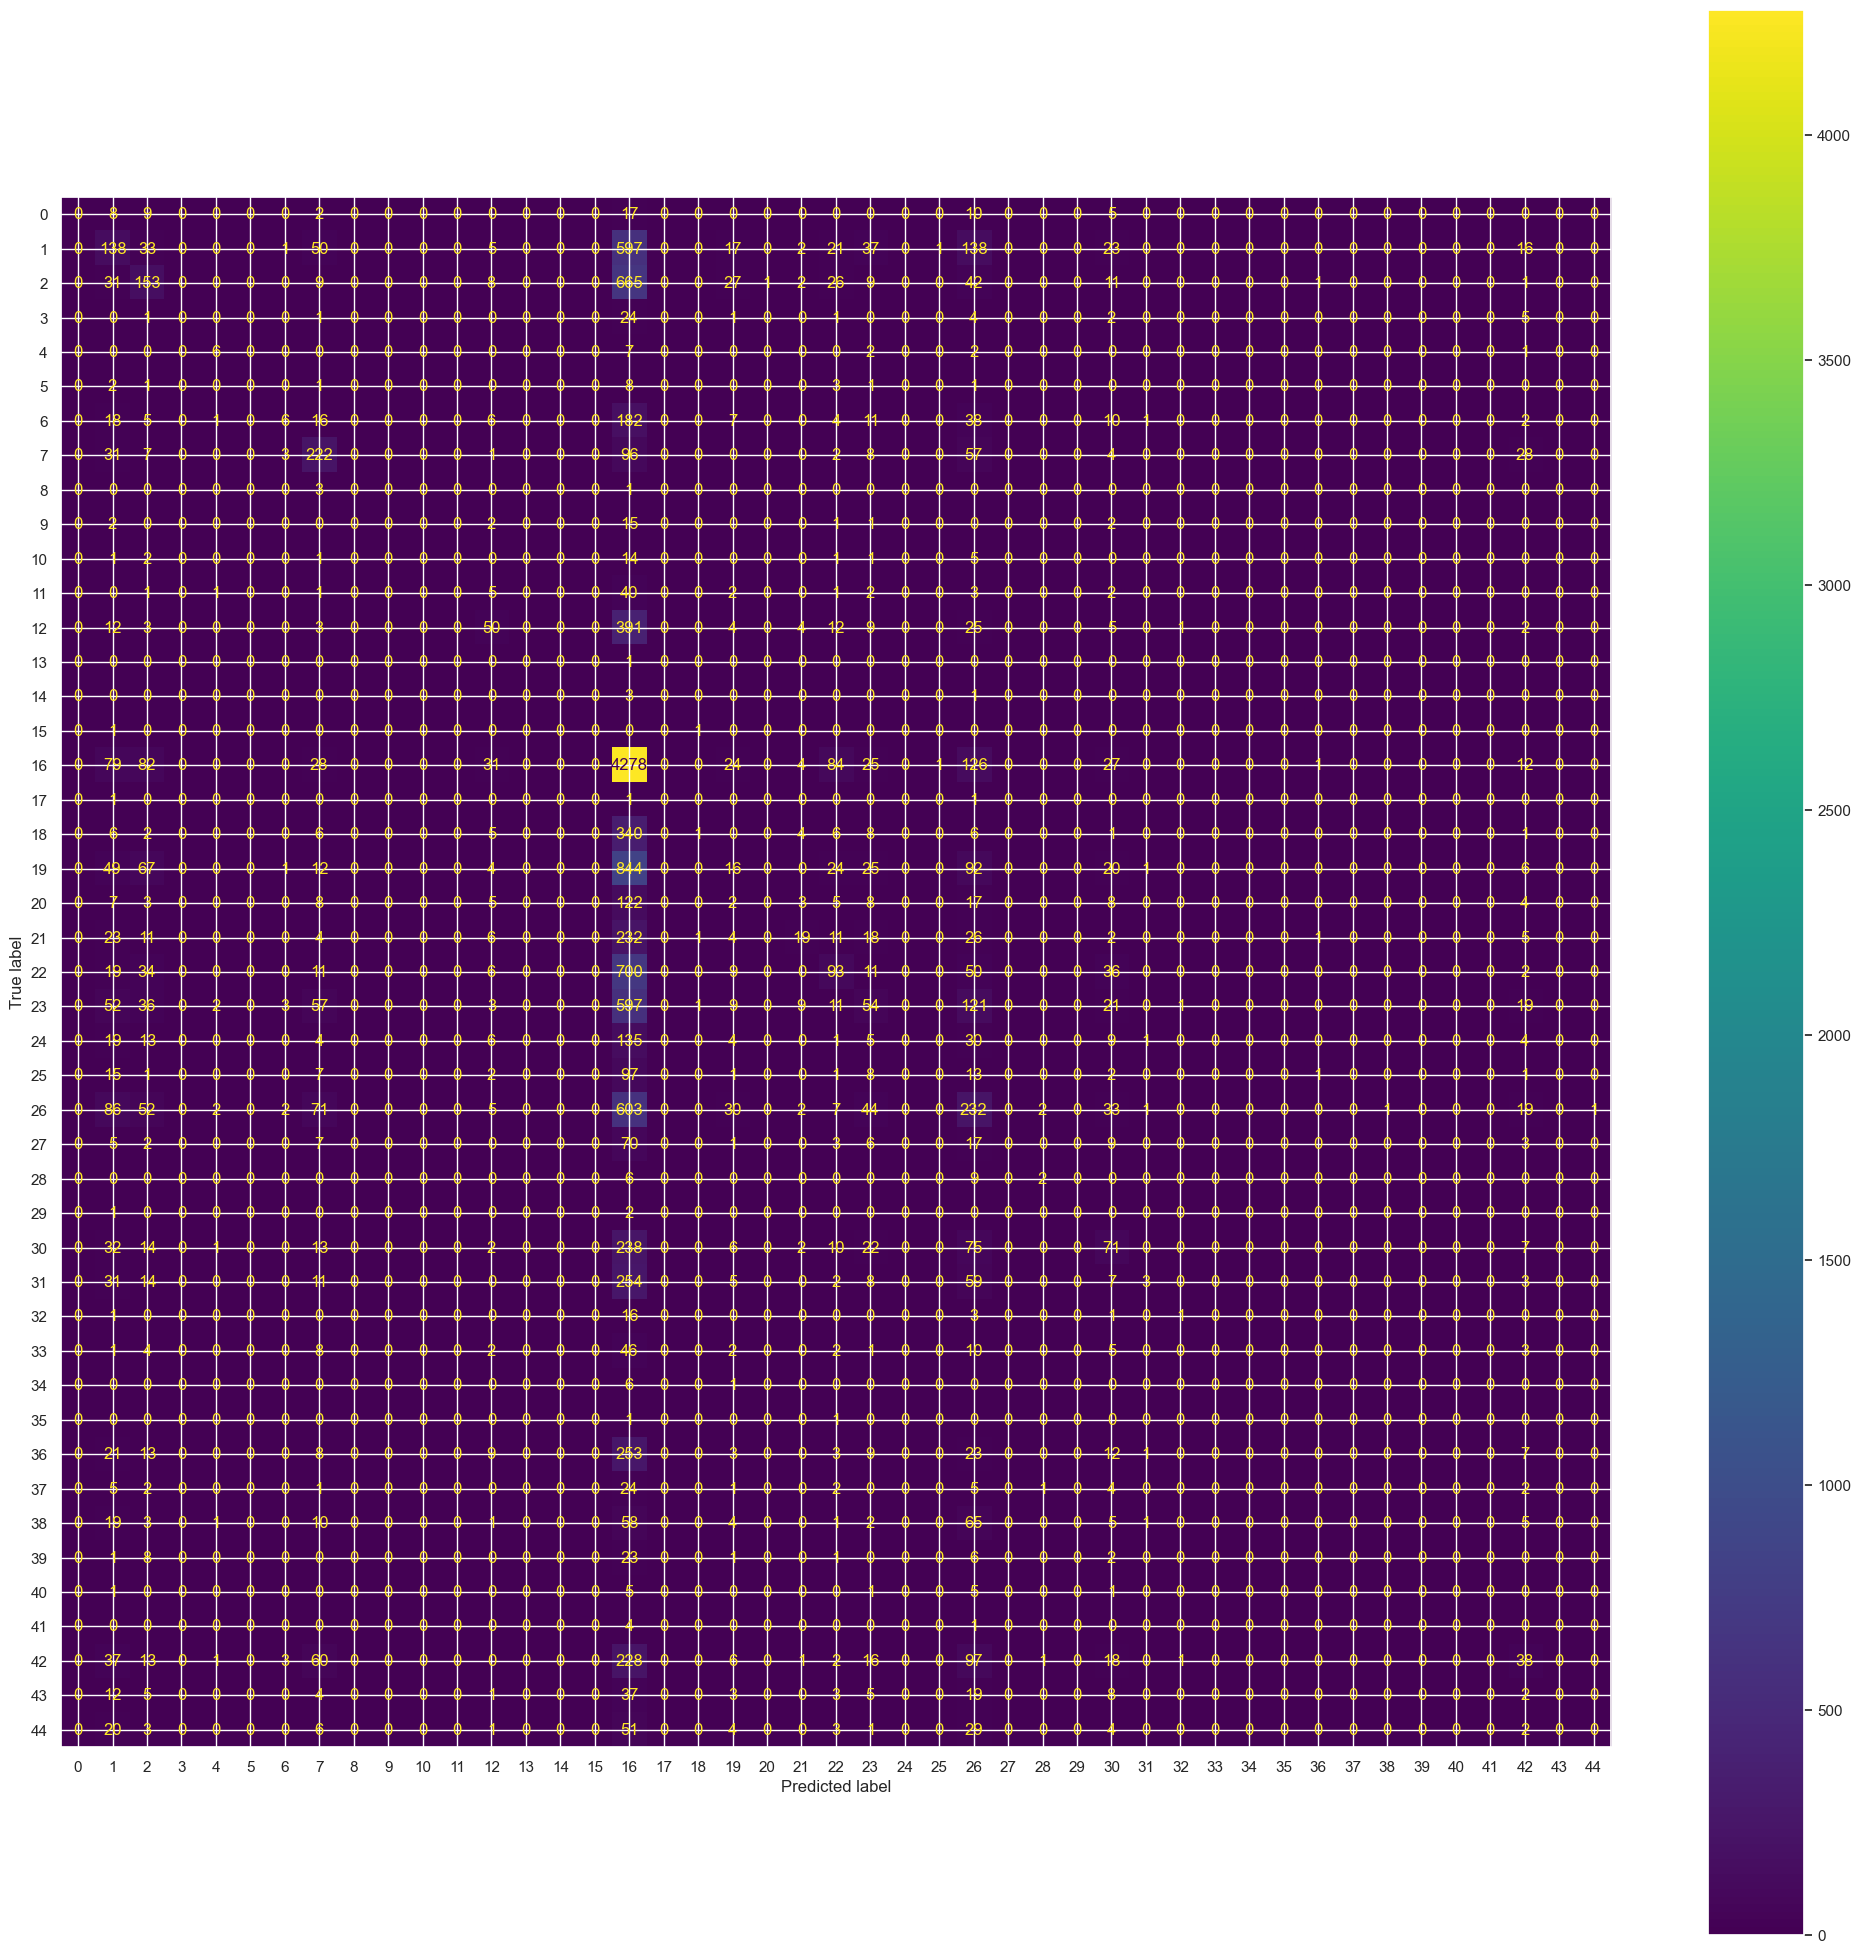

In [109]:
# for name, model in models.items():
for name, model in {best_model_idx : best_model}.items():
    print(f'Generating Confusion Matrix for {name}:')
    disp = ConfusionMatrixDisplay(results_CV[name]['cm'])

    # Generate the confusion matrix
    fig, ax = plt.subplots(figsize=(25, 25))
    disp.plot(ax=ax)
    # plt.tight_layout()
    plt.savefig(Config.IMAGE_DIR / f'Confusion_matrix_{name}.png')
    plt.show()

### Feature Importance

In [111]:
# Get the importance features as scored by the best_model
feature_importances = best_model.feature_importances_
        
# Normalize the feature importances
feature_importances = feature_importances / feature_importances.sum()
    
# Create a DataFrame with feature names and importances
imp_table = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
imp_table = imp_table.sort_values('Importance', ascending=False).reset_index(drop=True)

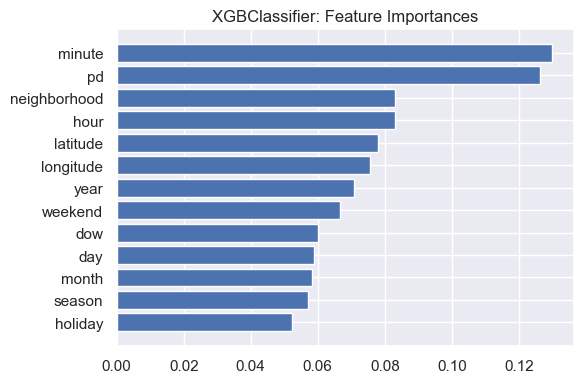

In [112]:
# Visualize feature importances
plt.figure(figsize=(6,4))

plt.barh(imp_table['Feature'], imp_table['Importance'])#, color='skyblue')
# ax.set_xlabel('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top

plt.title(f'{best_model_idx}: Feature Importances')

# Adjust layout to prevent overlap
plt.tight_layout()

if not Config.SUPPRESS_OUTPUT_FILES:
    plt.savefig(Config.IMAGE_DIR / 'best_feature_importances.png')

plt.show()

### LIME